<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-3/blob/main/VanilaAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip /content/drive/MyDrive/lexicons.zip > /dev/null

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN, GRU, SimpleRNN
from tensorflow.python.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed
from tensorflow.python.keras.models import Model
import math
from math import log

In [4]:
# Path to the data txt file on disk.
data_path = "/content/lexicons/hi.translit.sampled.train.tsv"
val_path = "/content/lexicons/hi.translit.sampled.dev.tsv"
test_path = "/content/lexicons/hi.translit.sampled.test.tsv"

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters.add(" ")
target_characters.add(" ")
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

val_input_texts = []
val_target_texts = []

with open(val_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    val_input_texts.append(input_text)
    val_target_texts.append(target_text)

test_input_texts = []
test_target_texts = []

with open(val_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_input_texts.append(input_text)
    test_target_texts.append(target_text)

print("Number of samples:", len(input_texts))
print("Number of validation samples:", len(val_input_texts))
print("Number of test samples:", len(test_input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of validation samples: 4358
Number of test samples: 4358
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [5]:
print("Train Set Samples")
for i in range (5):
  index = random. randint(0,len(target_texts))
  print(input_texts[index],target_texts[index])

Train Set Samples
nawaf 	नवाफ

eyarline 	एयरलाइन

cactus 	कैक्टस

poochhate 	पूछते

pattedar 	पत्तेदार



In [6]:
print("Validation Set Samples")
for i in range (5):
  index = random. randint(0,len(val_target_texts))
  print(val_input_texts[index],val_target_texts[index])

Validation Set Samples
peene 	पीने

aarch 	आर्च

ved 	वेद

ullekh 	उल्लेख

bani 	बनी



In [7]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
print(np.shape(encoder_input_data),np.shape(decoder_input_data),np.shape(decoder_target_data))

val_encoder_input_data = np.zeros((len(val_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
val_decoder_input_data = np.zeros((len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
val_decoder_target_data = np.zeros((len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
print(np.shape(val_encoder_input_data),np.shape(val_decoder_input_data),np.shape(val_decoder_target_data))

test_encoder_input_data = np.zeros((len(test_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
print(np.shape(test_encoder_input_data))

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

for i, (val_input_text, val_target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(val_input_text):
        val_encoder_input_data[i, t, input_token_index[char]] = 1.0
    val_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(val_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

for i, (test_input_text, ) in enumerate(zip(test_input_texts, )):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, input_token_index[char]] = 1.0
    test_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

(44204, 20, 27) (44204, 21, 66) (44204, 21, 66)
(4358, 20, 27) (4358, 21, 66) (4358, 21, 66)
(4358, 20, 27)


In [8]:
batch_size = 64  # Batch size for training.
epochs = 8  # Number of epochs to train for.
hidden_neurons = 64
dropout = 0.0
recc_dropout = 0.1

In [9]:
latent_dims = 256

In [10]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [13]:
# Define an input sequence and process it by going through a len(latent_dims)-layer deep encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens),name='encoder_inputs')
decoder_inputs = Input(shape=(None,num_decoder_tokens),name='decoder_inputs')
 
encoder_gru = SimpleRNN(latent_dims, return_sequences=True, return_state=True,name='encoder_rnn')
encoder_out, encoder_state = encoder_gru(encoder_inputs)
decoder_gru = SimpleRNN(latent_dims, return_sequences=True, return_state=True,name='decoder_rnn')
decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out,_ = attn_layer([encoder_out, decoder_out])

decoder_concat_input = Concatenate(axis=-1,name='concat_layer')([decoder_out, attn_out])

# Dense layer
dense = Dense(num_decoder_tokens, activation='softmax',name='softmax_layer')
dense_time = TimeDistributed(dense)
decoder_pred = dense_time(decoder_concat_input)

# Full model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 27)]   0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
encoder_rnn (SimpleRNN)         [(None, None, 256),  72704       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_rnn (SimpleRNN)         [(None, None, 256),  82688       decoder_inputs[0][0]             
                                                                 encoder_rnn[0][1]          

In [14]:
""" Encoder (Inference) model """
encoder_inputs = model.input[0]
encoder_inf_out, encoder_inf_state = model.layers[2].output
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_inf_out, encoder_inf_state])

""" Decoder (Inference) model """
decoder_inf_inputs = model.input[1]
encoder_inf_states = Input(shape=(None, latent_dims))
decoder_init_state = Input(shape=(latent_dims,))
decoder_gru=model.layers[3]
decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1,name='concat')([decoder_inf_out, attn_inf_out])
decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

In [15]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data))

Epoch 1/8
691/691 [==============================] - 54s 70ms/step - loss: 1.0386 - accuracy: 0.7405 - val_loss: 0.3121 - val_accuracy: 0.9037
Epoch 2/8
691/691 [==============================] - 48s 70ms/step - loss: 0.2867 - accuracy: 0.9118 - val_loss: 0.2116 - val_accuracy: 0.9356
Epoch 3/8
691/691 [==============================] - 47s 69ms/step - loss: 0.1874 - accuracy: 0.9410 - val_loss: 0.1724 - val_accuracy: 0.9458
Epoch 4/8
691/691 [==============================] - 48s 69ms/step - loss: 0.1597 - accuracy: 0.9488 - val_loss: 0.1736 - val_accuracy: 0.9440
Epoch 5/8
691/691 [==============================] - 48s 69ms/step - loss: 0.1443 - accuracy: 0.9536 - val_loss: 0.1660 - val_accuracy: 0.9473
Epoch 6/8
691/691 [==============================] - 48s 69ms/step - loss: 0.1329 - accuracy: 0.9571 - val_loss: 0.1627 - val_accuracy: 0.9483
Epoch 7/8
691/691 [==============================] - 48s 69ms/step - loss: 0.1247 - accuracy: 0.9596 - val_loss: 0.1575 - val_accuracy: 0.9507

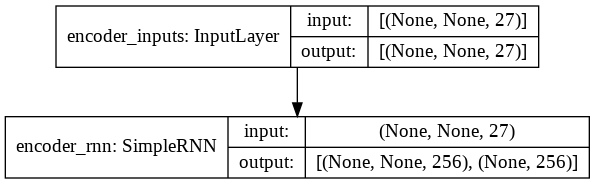

In [16]:
plot_model(encoder_model, show_shapes=True)

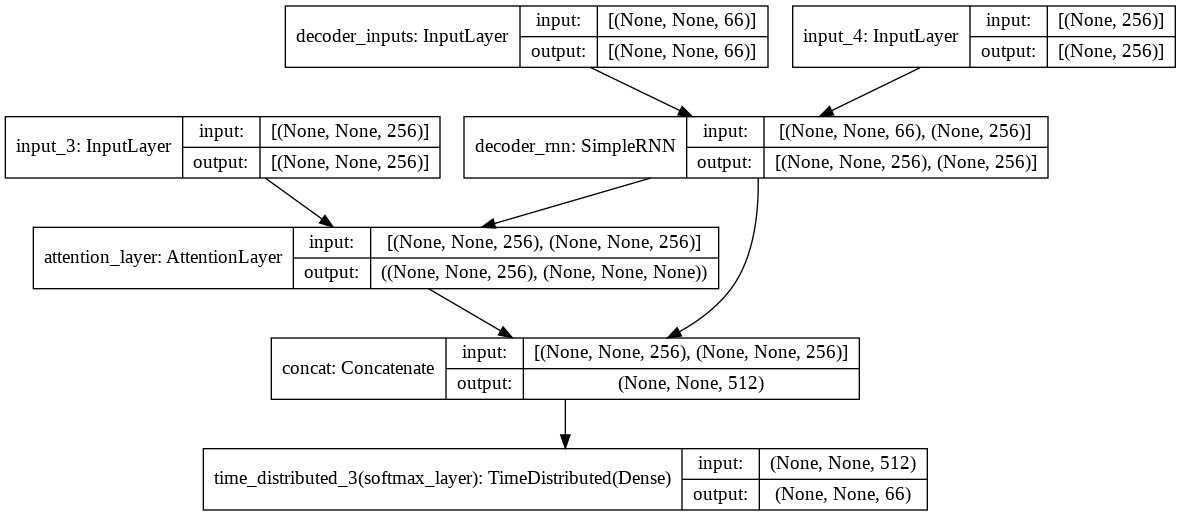

In [17]:
plot_model(decoder_model, show_shapes=True)

In [19]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [20]:
def decode_sequence(input_seq,beam_search):
    # Encode the input as state vectors.
    enc_outs, enc_last_state = encoder_model.predict(input_seq)
    dec_state = enc_last_state
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentences = []
    attention_weights = []
    if beam_search==0:
      decoded_sentence = []  #Creating a list then using "".join() is usually much faster for string creation
      while not stop_condition:
          dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, target_seq])
          dec_ind = np.argmax(dec_out[0, 0])
          attention_weights.append((dec_ind, attention))
          sampled_char = reverse_target_char_index[dec_ind]
          decoded_sentence.append(sampled_char)
          if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, dec_ind] = 1.
      decoded_sentences.append("".join(decoded_sentence))
    else:
      decoded_prob = []
      it=0
      while not stop_condition:
          dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, target_seq])
          dec_ind = np.argmax(dec_out[0, 0])
          attention_weights.append((dec_ind, attention))
          sampled_char = reverse_target_char_index[dec_ind]
          it += 1
          decoded_prob.append(dec_out[0, 0])
          if sampled_char == '\n' or it > max_decoder_seq_length:
            stop_condition = True
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, dec_ind] = 1.
      sequences = [[list(), 0.0]]
      # walk over each step in sequence
      for row in decoded_prob:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
          seq, score = sequences[i]
          for j in range(len(row)):
            candidate = [seq + [j], score - log(row[j])]
            all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:beam_search]
      for seq in sequences:
        decoded_sentence = []
        for char_in in seq[0]:
          sampled_char = reverse_target_char_index[char_in]
          decoded_sentence.append(sampled_char)
        decoded_sentences.append("".join(decoded_sentence))
    return decoded_sentences

In [21]:
valid = 0
beam_search=5
for i in range(200):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    seq_index=random.randint(0,len(test_input_texts))
    #seq_index=i
    input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq,beam_search)
    #print("-")
    #print("Input sentence:", test_input_texts[seq_index])
    #for seq in decoded_sentence:
      #print("Decoded sentence:", seq)
    #print("Actual sentence:", test_target_texts[seq_index])
    for translate in decoded_sentence:
      flag=1
      for (i,j) in zip(translate,test_target_texts[seq_index]):
        if i!=j:
          flag=0
          break
      if flag==1:
        valid += 1
        break
#print("Word Level Validation Accuracy :",valid/1000)
print(valid)

101
